In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import torch.nn.functional as F
import cv2
from PIL import Image
import albumentations as A
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torchvision.models as models

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Define the directories
image_dir = '/kaggle/input/drone-dataset/original_images'
mask_dir = '/kaggle/input/drone-dataset/label_images_semantic'

# Get list of image and mask files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.png')]

# Print the number of images and masks
print(f"Number of images in original_images: {len(image_files)}")
print(f"Number of masks in label_images_semantic: {len(mask_files)}")

Number of images in original_images: 400
Number of masks in label_images_semantic: 400


In [4]:
# Check for corresponding mask files
matched_files = []
for img_file in image_files:
    base_name = os.path.splitext(img_file)[0]
    mask_file = base_name + '.png'
    if mask_file in os.listdir(mask_dir):
        matched_files.append(img_file)
    else:
        print(f"Warning: Mask file for {img_file} not found.")

# Print the number of matched files
print(f"Number of matched image-mask pairs: {len(matched_files)}")

Number of matched image-mask pairs: 400


In [5]:
# Split into train, validation, and test sets
train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

print(f"Training files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Testing files: {len(test_files)}")

Training files: 240
Validation files: 80
Testing files: 80


In [6]:
# Define mean and std
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define transformations
t_train = A.Compose([
    A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.GridDistortion(p=0.2),
    A.RandomBrightnessContrast((0, 0.5), (0, 0.5)),
    A.GaussNoise()
])

t_val = A.Compose([
    A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(),
    A.GridDistortion(p=0.2)
])

In [7]:
# Custom Dataset class
class DroneDataset(Dataset):
    def __init__(self, image_dir, mask_dir, files, mean, std, transform=None, patch=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.files = files
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        # Retrieve the image and mask file names
        img_file = self.files[idx]
        base_name = os.path.splitext(img_file)[0]
        
        # Build the file paths for the image and mask using the provided index
        img_path = os.path.join(self.image_dir, img_file)            # Path to the input image
        mask_path = os.path.join(self.mask_dir, base_name + '.png')  # Path to the corresponding segmentation mask

        # Read the image and mask
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image file not found: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Mask file not found: {mask_path}")

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):
        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches = img_patches.contiguous().view(3, -1, 512, 768)
        img_patches = img_patches.permute(1, 0, 2, 3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [8]:
# Create datasets
train_dataset = DroneDataset(image_dir=image_dir, mask_dir=mask_dir, files=train_files, mean=mean, std=std, transform=t_train, patch=False)
val_dataset = DroneDataset(image_dir=image_dir, mask_dir=mask_dir, files=val_files, mean=mean, std=std, transform=t_val, patch=False)
test_dataset = DroneDataset(image_dir=image_dir, mask_dir=mask_dir, files=test_files, mean=mean, std=std, transform=t_val, patch=False)

# Create dataloaders
BATCH_SIZE = 3
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Example usage: Print the shapes of images and masks in the train_loader
#for images, masks in test_loader:
#    print(f"Images shape: {images.shape}")
#    print(f"Masks shape: {masks.shape}")
#    break  # Print the shapes for one batch and exit the loop

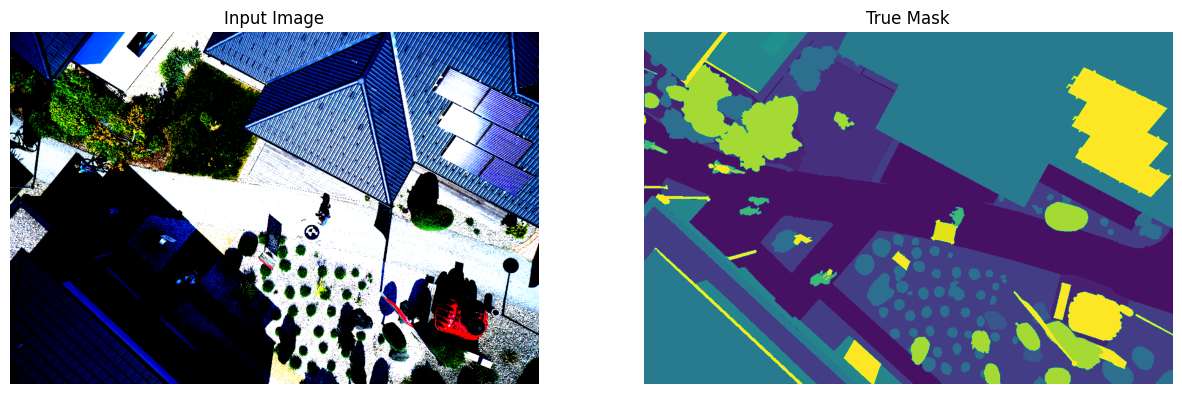

In [9]:
# Define the display function
def display(display_list):
    """
    Display the input image and true mask.
    
    Args:
        display_list (list of torch.Tensor): List containing the input image and true mask.
    """
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        
        # If displaying the mask, use gray colormap
        if title[i] == "True Mask":
            plt.imshow(display_list[i].cpu())
        else:
            plt.imshow(display_list[i].cpu().permute(1, 2, 0))
        
        plt.axis("off")
    plt.show()

# Get a batch of test data
test_batch = next(iter(test_loader))

# Select a random index from the batch
random_index = np.random.choice(test_batch[0].shape[0])

# Get the input image and true mask
sample_image, sample_mask = test_batch[0][random_index], test_batch[1][random_index]

# Display the input image and true mask
display([sample_image, sample_mask])

In [9]:
class ResNetSegmentation(nn.Module):
    def __init__(self, num_classes):
        super(ResNetSegmentation, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])  # Remove the last two layers
        self.conv1 = nn.Conv2d(2048, 1024, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(1024, num_classes, kernel_size=1)
        self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=True)
    
    def forward(self, x):
        x = self.resnet(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.upsample(x)
        return x

# Instantiate the model
num_classes = 24  # Number of segmentation classes
model = ResNetSegmentation(num_classes).to(device)



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 143MB/s] 


In [10]:
import time

In [11]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=24):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(n_classes):
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []
    val_acc = []
    train_iou = []
    train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1
    not_improve = 0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()
                image_tiles = image_tiles.view(-1, c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device)
            mask = mask_tiles.to(device)
            output = model(image)
            loss = criterion(output, mask)
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            running_loss += loss.item()
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image_tiles, mask_tiles = data
                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()
                        image_tiles = image_tiles.view(-1, c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device)
                    mask = mask_tiles.to(device)
                    output = model(image)
                    val_iou_score += mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))

            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    
            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {
        'train_loss': train_losses,
        'val_loss': test_losses,
        'train_miou': train_iou,
        'val_miou': val_iou,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'lrs': lrs
    }
    print('Total time: {:.2f} m' .format((time.time()-fit_time)/60))
    return history

max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch, steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.122 
Epoch:1/15.. Train Loss: 1.776.. Val Loss: 2.122.. Train mIoU:0.116.. Val mIoU: 0.176.. Train Acc:0.553.. Val Acc:0.687.. Time: 3.68m


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 2.122 >> 0.966 
Epoch:2/15.. Train Loss: 1.365.. Val Loss: 0.966.. Train mIoU:0.188.. Val mIoU: 0.213.. Train Acc:0.644.. Val Acc:0.710.. Time: 3.35m


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:3/15.. Train Loss: 1.498.. Val Loss: 1.333.. Train mIoU:0.164.. Val mIoU: 0.134.. Train Acc:0.609.. Val Acc:0.590.. Time: 3.29m


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:4/15.. Train Loss: 1.521.. Val Loss: 2.021.. Train mIoU:0.147.. Val mIoU: 0.099.. Train Acc:0.579.. Val Acc:0.489.. Time: 3.33m


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 2.021 >> 1.352 
Epoch:5/15.. Train Loss: 1.534.. Val Loss: 1.352.. Train mIoU:0.125.. Val mIoU: 0.127.. Train Acc:0.567.. Val Acc:0.586.. Time: 3.33m


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 1.352 >> 1.061 
saving model...
Epoch:6/15.. Train Loss: 1.330.. Val Loss: 1.061.. Train mIoU:0.158.. Val mIoU: 0.203.. Train Acc:0.609.. Val Acc:0.689.. Time: 3.35m


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:7/15.. Train Loss: 1.226.. Val Loss: 1.374.. Train mIoU:0.186.. Val mIoU: 0.173.. Train Acc:0.630.. Val Acc:0.660.. Time: 3.36m


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:8/15.. Train Loss: 1.086.. Val Loss: 1.649.. Train mIoU:0.207.. Val mIoU: 0.169.. Train Acc:0.675.. Val Acc:0.648.. Time: 3.38m


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 1.649 >> 0.920 
Epoch:9/15.. Train Loss: 1.034.. Val Loss: 0.920.. Train mIoU:0.225.. Val mIoU: 0.256.. Train Acc:0.695.. Val Acc:0.735.. Time: 3.41m


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 0.920 >> 0.846 
Epoch:10/15.. Train Loss: 0.867.. Val Loss: 0.846.. Train mIoU:0.267.. Val mIoU: 0.259.. Train Acc:0.739.. Val Acc:0.735.. Time: 3.36m


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 0.846 >> 0.695 
Epoch:11/15.. Train Loss: 0.761.. Val Loss: 0.695.. Train mIoU:0.298.. Val mIoU: 0.323.. Train Acc:0.762.. Val Acc:0.784.. Time: 3.40m


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 0.695 >> 0.679 
Epoch:12/15.. Train Loss: 0.708.. Val Loss: 0.679.. Train mIoU:0.312.. Val mIoU: 0.325.. Train Acc:0.777.. Val Acc:0.783.. Time: 3.41m


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 0.679 >> 0.615 
saving model...
Epoch:13/15.. Train Loss: 0.626.. Val Loss: 0.615.. Train mIoU:0.340.. Val mIoU: 0.344.. Train Acc:0.800.. Val Acc:0.806.. Time: 3.39m


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 0.615 >> 0.612 
Epoch:14/15.. Train Loss: 0.616.. Val Loss: 0.612.. Train mIoU:0.345.. Val mIoU: 0.353.. Train Acc:0.804.. Val Acc:0.802.. Time: 3.39m


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:15/15.. Train Loss: 0.604.. Val Loss: 0.641.. Train mIoU:0.349.. Val mIoU: 0.355.. Train Acc:0.807.. Val Acc:0.796.. Time: 3.40m
Total time: 50.81 m


In [12]:
torch.save(model, 'ResNet-Bigboss.pt')

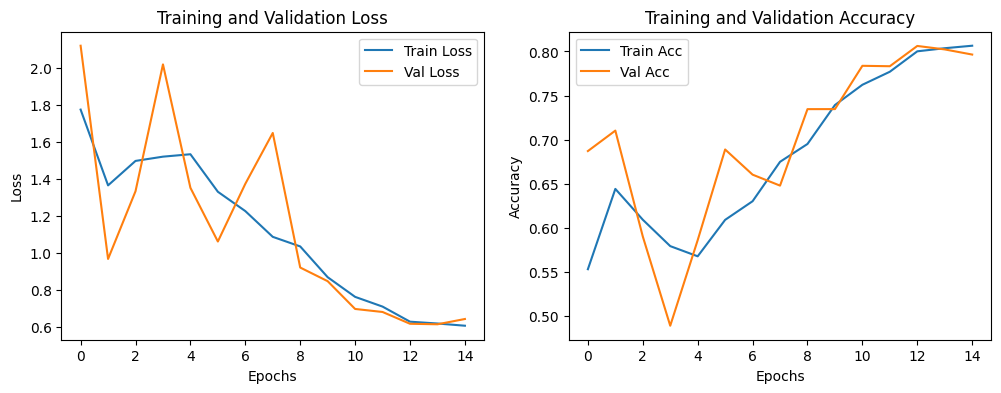

In [13]:
# Plotting training and validation metrics
num_epochs = epoch

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), history['train_loss'], label='Train Loss')
plt.plot(range(num_epochs), history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), history['train_acc'], label='Train Acc')
plt.plot(range(num_epochs), history['val_acc'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

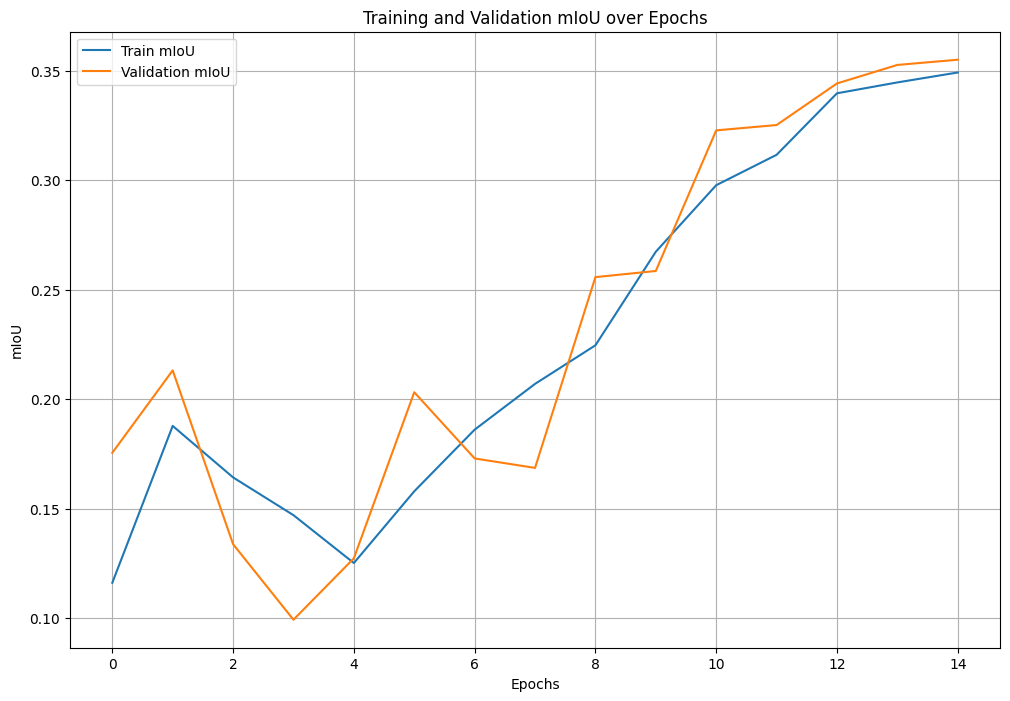

In [21]:
# Plotting training and validation mIoU
plt.figure(figsize=(12, 8))
plt.plot(range(num_epochs), history['train_miou'], label='Train mIoU')
plt.plot(range(num_epochs), history['val_miou'], label='Validation mIoU')
plt.xlabel('Epochs')
plt.ylabel('mIoU')
plt.title('Training and Validation mIoU over Epochs')
plt.legend()
plt.grid(True)
plt.show()

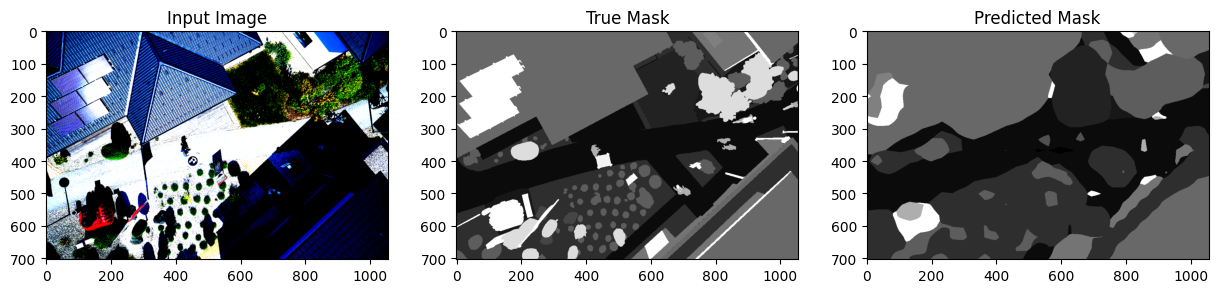

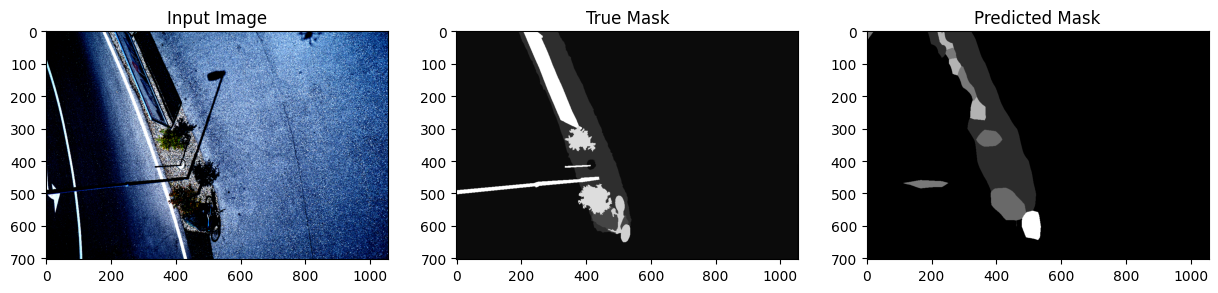

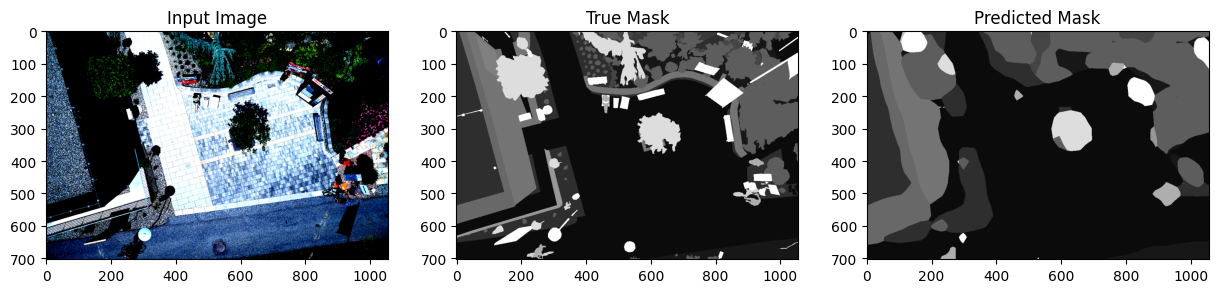

In [14]:
# Visualize predictions
def visualize_predictions(images, masks, outputs, n=3):
    for i in range(n):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(images[i].cpu().permute(1, 2, 0))
        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(masks[i].cpu(), cmap='gray')
        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        _, preds = torch.max(outputs[i], dim=0)
        plt.imshow(preds.cpu(), cmap='gray')
        plt.show()

# Get a batch of test data
test_batch = next(iter(test_loader))
test_images, test_masks = test_batch
test_images = test_images.to(device)
test_outputs = model(test_images)

visualize_predictions(test_images, test_masks, test_outputs)

In [19]:
# Path to the model file in the dataset
model_path = '/kaggle/input/resnet-buse/ResNet-Bigboss.pt'

# Load the model
model = torch.load(model_path)
model.eval()  # Set the model to evaluation mode

ResNetSegmentation(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): C

In [15]:
# Get a batch of test data
test_batch = next(iter(test_loader))
test_images, test_masks = test_batch
test_images = test_images.to(device)

# Generate predictions
test_outputs = model(test_images)
_, preds = torch.max(test_outputs, dim=1)

# Move predictions and masks to CPU for analysis
preds = preds.cpu().numpy()
test_masks = test_masks.cpu().numpy()


In [16]:
# Define class indices mapping (if necessary)
class_mapping = {
    0: "unlabeled",
    1: "paved-area",
    2: "dirt",
    3: "grass",
    4: "gravel",
    5: "water",
    6: "rocks",
    7: "pool",
    8: "vegetation",
    9: "roof",
    10: "wall",
    11: "window",
    12: "door",
    13: "fence",
    14: "fence-pole",
    15: "person",
    16: "dog",
    17: "car",
    18: "bicycle",
    19: "tree",
    20: "bald-tree",
    21: "ar-marker",
    22: "obstacle",
    23: "conflicting"
}

# Check predicted class indices and corresponding class names
for i in range(len(preds)):
    unique_pred_classes = np.unique(preds[i])
    unique_true_classes = np.unique(test_masks[i])
    print(f"Image {i + 1}")
    print("Predicted Classes:")
    for cls in unique_pred_classes:
        print(f"Class Index: {cls}, Class Name: {class_mapping.get(cls, 'Unknown')}")
    print("True Classes:")
    for cls in unique_true_classes:
        print(f"Class Index: {cls}, Class Name: {class_mapping.get(cls, 'Unknown')}")
    print("-" * 30)


Image 1
Predicted Classes:
Class Index: 0, Class Name: unlabeled
Class Index: 1, Class Name: paved-area
Class Index: 2, Class Name: dirt
Class Index: 3, Class Name: grass
Class Index: 4, Class Name: gravel
Class Index: 6, Class Name: rocks
Class Index: 7, Class Name: pool
Class Index: 8, Class Name: vegetation
Class Index: 9, Class Name: roof
Class Index: 10, Class Name: wall
Class Index: 11, Class Name: window
Class Index: 15, Class Name: person
Class Index: 17, Class Name: car
Class Index: 22, Class Name: obstacle
True Classes:
Class Index: 0, Class Name: unlabeled
Class Index: 1, Class Name: paved-area
Class Index: 2, Class Name: dirt
Class Index: 3, Class Name: grass
Class Index: 4, Class Name: gravel
Class Index: 6, Class Name: rocks
Class Index: 8, Class Name: vegetation
Class Index: 9, Class Name: roof
Class Index: 10, Class Name: wall
Class Index: 11, Class Name: window
Class Index: 15, Class Name: person
Class Index: 18, Class Name: bicycle
Class Index: 19, Class Name: tree
Cl

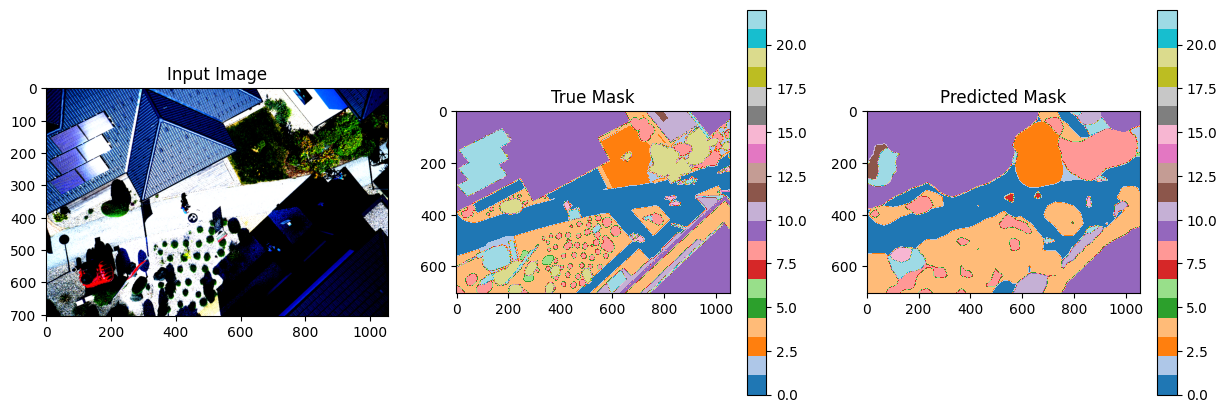

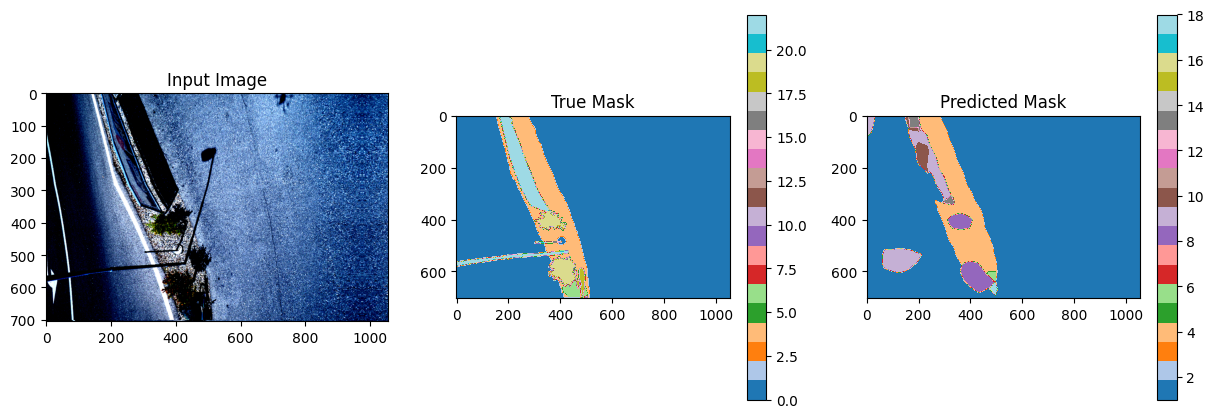

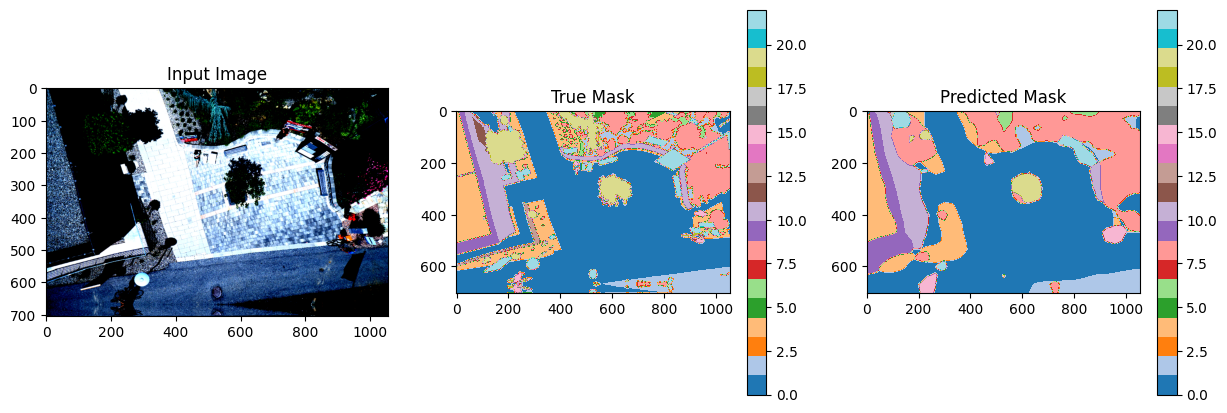

In [17]:
# Visualize the predicted and true masks
def visualize_predictions(images, true_masks, preds, class_mapping, n=3):
    for i in range(n):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(images[i].cpu().permute(1, 2, 0))
        
        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(true_masks[i], cmap='tab20')
        plt.colorbar()
        
        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(preds[i], cmap='tab20')
        plt.colorbar()
        
        plt.show()

# Visualize a few predictions
visualize_predictions(test_images.cpu(), test_masks, preds, class_mapping, n=3)


Guiding drone to landing spot at coordinates: (528, 352)


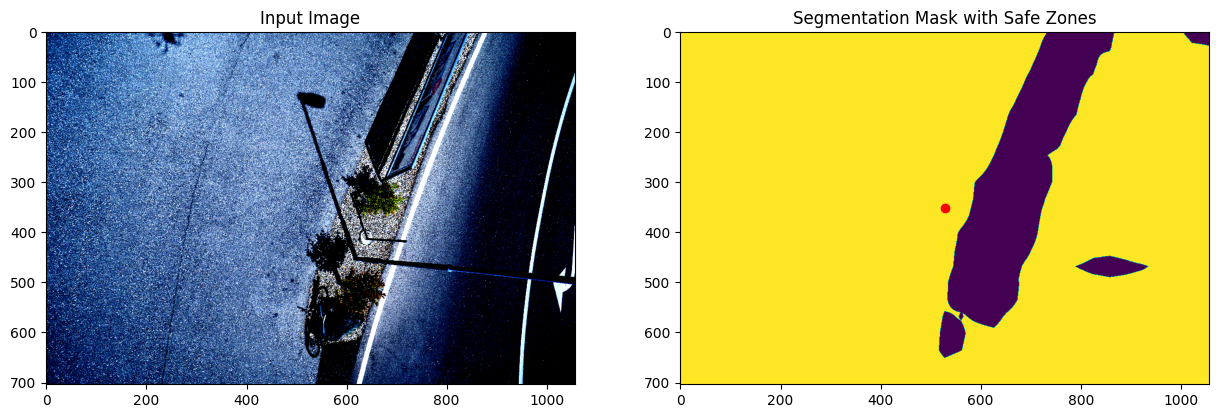

In [18]:
# Identify safe zones based on class indices
def identify_safe_zones(segmentation_mask, safe_class_indices, min_area=500):
    """
    Identify safe landing zones in the segmentation mask.

    Args:
        segmentation_mask (np.ndarray): The segmentation mask.
        safe_class_indices (list): List of class indices considered safe.
        min_area (int): Minimum area in pixels for a safe zone to be considered.

    Returns:
        list: List of bounding boxes of safe zones.
    """
    safe_mask = np.isin(segmentation_mask, safe_class_indices)
    safe_mask = safe_mask.astype(np.uint8) * 255  # Convert to binary mask

    # Find contours of the safe zones
    contours, _ = cv2.findContours(safe_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    safe_zones = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area >= min_area:
            x, y, w, h = cv2.boundingRect(contour)
            safe_zones.append((x, y, w, h))

    return safe_zones

def select_landing_spot(safe_zones):
    """
    Select the best landing spot from the identified safe zones.

    Args:
        safe_zones (list): List of bounding boxes of safe zones.

    Returns:
        tuple: Coordinates of the selected landing spot (x, y).
    """
    if not safe_zones:
        return None  # No safe zones found

    # Select the largest safe zone
    best_zone = max(safe_zones, key=lambda box: box[2] * box[3])
    x, y, w, h = best_zone
    landing_spot = (x + w // 2, y + h // 2)  # Center of the bounding box

    return landing_spot

# Guide the drone
def guide_drone_to_landing(landing_spot):
    """
    Guide the drone to the selected landing spot.

    Args:
        landing_spot (tuple): Coordinates of the selected landing spot (x, y).
    """
    if landing_spot is None:
        print("No suitable landing spot found.")
        return

    x, y = landing_spot
    print(f"Guiding drone to landing spot at coordinates: ({x}, {y})")


# Get a single image from the test data
test_image, test_mask = next(iter(test_loader))
test_image = test_image[1].unsqueeze(0).to(device)
test_mask = test_mask[1].unsqueeze(0).cpu().numpy()

# Generate prediction for the single image
with torch.no_grad():
    test_output = model(test_image)
    _, pred = torch.max(test_output, dim=1)

# Move predictions to CPU for processing
pred = pred.cpu().numpy()[0]

# Safe and unsafe classes by name
safe_classes = ["paved-area", "dirt", "grass"]
unsafe_classes = ["unlabeled","water", "rocks", "pool", "vegetation","roof", "obstacle","wall","window","door","fence","fence-pole","person","dog","car","bicycle","tree","bald-tree","ar-marker","conflicting","gravel"]

# Map safe and unsafe classes to their indices
safe_class_indices = [index for index, name in class_mapping.items() if name in safe_classes]
unsafe_class_indices = [index for index, name in class_mapping.items() if name in unsafe_classes]

# Identify safe zones in the predicted mask
safe_zones = identify_safe_zones(pred, safe_class_indices)

# Select the best landing spot
landing_spot = select_landing_spot(safe_zones)

# Guide the drone to the landing spot
guide_drone_to_landing(landing_spot)

# Visualize the result
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(test_image.cpu().squeeze().permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.title("Segmentation Mask with Safe Zones")
safe_mask = np.isin(pred, safe_class_indices).astype(np.uint8) * 255
plt.imshow(safe_mask)
if landing_spot:
    plt.plot(landing_spot[0], landing_spot[1], 'ro')  # Mark the landing spot
plt.show()
